In [98]:
from __future__ import annotations

import particle_in_a_box as pib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import default_plot as dp

plt.rcParams["text.usetex"] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Dejavu Serif'
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['axes.labelsize'] = 10
plt.rcParams["xtick.direction"] = "inout"
plt.rcParams["ytick.direction"] = "inout"

In [10]:
# Demo State
L = np.pi
m = 1
gamma = 10000
states = [5]
amps = [1]
theta = 0

pib_state_1 = pib.Particle_in_Box_State("symmetric", L, m, states, amps, gamma, 0)
pib_state_2 = pib.Particle_in_Box_State("symmetric", L, m, states, amps, gamma, np.pi)


adding state(s):  [5]
current config:  [5]
adding state(s):  [5]
current config:  [5]


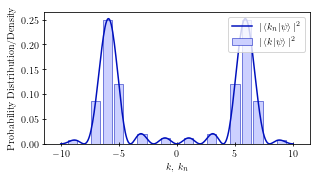

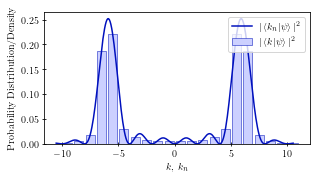

In [55]:
# Create Plots showing the single energy state momentum distributions for different values of theta
fig1 = plt.figure(tight_layout = True, figsize=(4.5,2.5))
p1 = dp.Momentum_Space_Plot(pib_state_1, fig1)
p1.set_n_bound(10)
p1.plot(0)
p1.k_lines[0].set_label(r"$\vert \left \langle k_n \middle \vert \psi \right \rangle \vert^2$")
p1.k_bars.set_label(r"$\vert \left \langle k \middle \vert \psi \right \rangle \vert^2$")
p1.axis.legend(loc="upper right")
plt.savefig("..\\Thesis\\Figures\\dirichlet_5th_state_momentum_distr_theta_0.pdf")

fig2 = plt.figure(tight_layout = True, figsize=(4.5,2.5))
p2 = dp.Momentum_Space_Plot(pib_state_2, fig2)
p2.set_n_bound(10)
p2.plot(0)
p2.k_lines[0].set_label(r"$\vert \left \langle k_n \middle \vert \psi \right \rangle \vert^2$")
p2.k_bars.set_label(r"$\vert \left \langle k \middle \vert \psi \right \rangle \vert^2$")
#p1.axis.tick_params('y', left=False, right=True, labelleft=False, labelright=True)
p2.axis.legend(loc="upper right")
plt.savefig("..\\Thesis\\Figures\\dirichlet_5th_state_momentum_distr_theta_pi.pdf")

In [4]:
class wavepacket:
    def __init__(self, k_0, alpha, x_0) -> None:
        self.k_0 = k_0
        self.alpha = alpha
        self.x_0 = x_0

    def __call__(self, x) -> np.ndarray:
        return np.power(self.alpha/np.pi, 1/4)*np.exp(1j*self.k_0*(x-self.x_0))*np.exp(-self.alpha/2*(x-self.x_0)**2)

class phi:
    def __init__(self, n, L, sign, func) -> None:
        self.n = n
        self.L = L 
        self.func = func
        self.sign = 1 if sign=="plus" else -1
    
    def sumup(self, x):
        out = np.zeros(np.shape(x), dtype=complex)
        for k in range(0, self.n//2+1):
            out += self.func(x + self.sign*2*k*self.L)

        for k in range(0, (self.n-1)//2+1):
            out -= self.func(-x + self.sign*(2*k+1)*self.L)

        return out        
        
    def __call__(self, x):
        #norm = quad(lambda x: np.abs(self.sumup(x))**2, -np.inf, np.inf)[0]
        norm = 1
        return self.sumup(x)/np.sqrt(norm)

    def any_step(self, n, x):
        return self.func(x*(-1)**(n) + self.sign*(n)*self.L)

    def next_step(self, x):
        return self.any_step(self.n+1, x)

    def current_step(self, x):
        return self.any_step(self.n, x)
    
    def prev_step(self, x):
        return self.any_step(self.n-1, x)

In [23]:
# Colors
import colorsys as cs
light_blue = cs.hls_to_rgb(235/360, 0.87, 1)
dark_blue = cs.hls_to_rgb(235/360, 0.37, 1)
light_red = cs.hls_to_rgb(0, 0.87, 1)
mid_red = cs.hls_to_rgb(0, 0.67, 1)
dark_red = cs.hls_to_rgb(0, 0.37, 1)

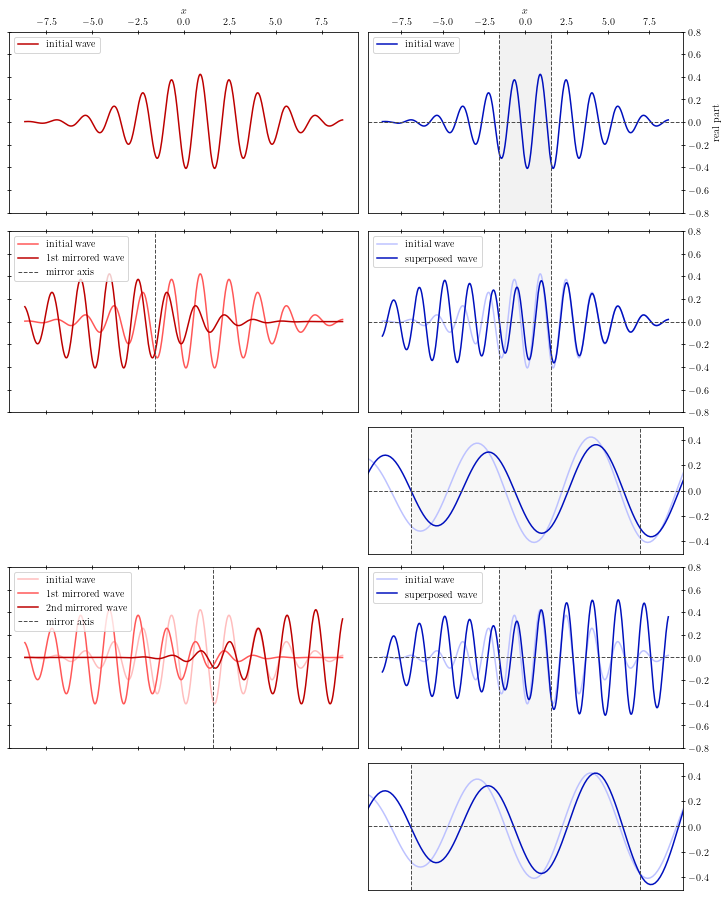

In [100]:
L = np.pi
nrows=3
fig = plt.figure(constrained_layout=True, figsize=(10,15))
gs = fig.add_gridspec(nrows=2*nrows, ncols=4, width_ratios=(1, 0.3, 0.3, 0.3), height_ratios=(1, 1, 0.7, 1, 0.7, 1))
ax = [[],[],[]]

impose_lines = []

x_lim_1 = L/2*(5.5)
x_lim_2 = L
x_lim_2 = x_lim_1*0.25

x = np.linspace(-x_lim_1, x_lim_1, 500)
wave = wavepacket(4, 0.1, 0.9)
phi_m = phi(0, L, "minus", wave)

init_ax = fig.add_subplot(gs[0,1:])
init_ax.plot(x, np.real(wave(x)), c=dark_blue, label="initial wave")
init_ax.legend(loc="upper left")
init_ax.set_ylim([-0.8, 0.8])
init_ax.axvspan(-L/2, L/2, color="0.95")
init_ax.axvline(-L/2, color="0.3", linewidth=1, linestyle="--")
init_ax.axvline(L/2, color="0.3", linewidth=1, linestyle="--")
init_ax.axhline(0, color="0.3", linewidth=1, linestyle="--")
init_ax.xaxis.tick_top()
init_ax.yaxis.tick_right()
init_ax.tick_params(axis="both", right=True, labelleft=False, labelbottom=False, bottom=True)
init_ax.xaxis.set_label_position("top")
init_ax.yaxis.set_label_position("right")
init_ax.set_xlabel("$x$")
init_ax.set_ylabel("real part")


init_ax_r = fig.add_subplot(gs[0,0], sharey=init_ax)
init_ax_r.plot(x, np.real(wave(x)), c=dark_red, label="initial wave")
init_ax_r.legend(loc="upper left")
init_ax_r.xaxis.tick_top()
init_ax_r.tick_params(axis="both", labelbottom=False, bottom=True, labelleft=False)
init_ax_r.xaxis.set_label_position("top")
init_ax_r.set_xlabel("$x$")


for i in range(1, nrows):
    ax[0].append(fig.add_subplot(gs[2*i-1,0], sharex=init_ax, sharey=init_ax))
    ax[1].append(fig.add_subplot(gs[2*i-1,1:], sharex=init_ax_r, sharey=init_ax_r))
    ax[2].append(fig.add_subplot(gs[2*i,1:]))
    axis_0 = ax[0][-1]

    if i >= 2:
        impose_lines.append(axis_0.plot(x, np.real(phi_m.prev_step(x)), c=light_red))
    impose_lines.append(axis_0.plot(x, np.real(phi_m.current_step(x)), c=mid_red))
    impose_lines.append(axis_0.plot(x, np.real(phi_m.next_step(x)), c=dark_red))
    axis_0.axvline((L/2)*(-1)**i, color="0.3", linewidth=1, linestyle="--", label="mirror axis")
    axis_0.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labelleft=False)

    phi_m.n += 1
    for i in range(2):
        axis = ax[i+1][-1]
        axis.plot(x, np.real(wave(x)), c=light_blue, label="initial wave")
        axis.plot(x, np.real(phi_m(x)), c=dark_blue, label="superposed wave")
        axis.axvspan(-L/2, L/2, color="0.97")
        axis.axvline(-L/2, color="0.3", linewidth=1, linestyle="--")
        axis.axvline(L/2, color="0.3", linewidth=1, linestyle="--")
        axis.axhline(0, color="0.3", linewidth=1, linestyle="--")
        axis.tick_params(axis="both", left=False, right=True, top=True, labelleft=False, labelright=True, bottom=True, labelbottom=False)
    
    ax[1][-1].legend(loc="upper left")
    ax[2][-1].set_xlim([-x_lim_2, x_lim_2])
    ax[2][-1].set_ylim([-0.5, 0.5])
    ax[2][-1].tick_params(axis="both", bottom=False, top=False, labelbottom=False)

impose_lines[0][0].set_label("initial wave")
impose_lines[1][0].set_label("1st mirrored wave")
impose_lines[2][0].set_label("initial wave")
impose_lines[3][0].set_label("1st mirrored wave")
impose_lines[4][0].set_label("2nd mirrored wave")

for i in range(0, nrows-1):
    ax[0][i].legend(loc="upper left")


plt.savefig("..\\Thesis\\Figures\\wrapping_dirichlet.pdf")
